# Overlapping Genes Benchmark Analysis

This notebook contains tools to benchmark the performance and behavior of the overlapping genes simulation.

## Benchmarks Included:
1.  **Time to Convergence vs Overlap Length**: Measures how scaling the overlap affects runtime.
2.  **Convergence Traces**: Plots the energy trajectory of individual runs to verify convergence behavior.
3.  **Sequence Diversity**: Analyzes the diversity of generated sequences using Hamming distance.

In [10]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
import traceback

# Add current directory to path to import overlappingGenes
sys.path.append(os.getcwd())
import overlappingGenes as og

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

In [11]:
# --- CONFIGURATION ---

# General
NUM_TRIALS = 200              # Number of independent trials per condition
MAX_ITERATIONS = 100_000_000 # Max steps for convergence check

# Benchmark 1: Scaling
OVERLAP_LENGTHS = og.get_optimal_overlaps(12, 102, 3) # Overlaps to test for scaling

# Benchmark 2: Traces
TRACE_OVERLAP = 60           # Overlap length for trace plotting
TRACE_ITERATIONS = 1_000_000      # Number of iterations to plot for traces
TRACE_TRIALS = 5             # Number of trials to plot

# Benchmark 3: Diversity
DIVERSITY_OVERLAPS = [10, 40, 70, 95] # Overlaps to analyze for diversity
DIVERSITY_TRIALS = 20        # Number of sequences to generate per overlap

# Simulation Parameters
T1 = 0.8
T2 = 0.93

In [12]:
# --- HELPER FUNCTIONS ---

def load_dca_params(base_dir, pf_name):
    params_file = os.path.join(base_dir, pf_name, f"{pf_name}_params.dat")
    print(f"Loading parameters from {params_file}...")
    J, h = og.extract_params(params_file)
    return (J, h)

def load_natural_energies_stats(base_dir, pf_name):
    filename = os.path.join(base_dir, pf_name, f"{pf_name}_naturalenergies.txt")
    energies = og.load_natural_energies(filename)
    return np.mean(energies), np.std(energies)

# Load Data Once
base_dir = os.getcwd()
dca_params_1 = load_dca_params(base_dir, "PF00004")
dca_params_2 = load_dca_params(base_dir, "PF00041")

mean_e1, std_e1 = load_natural_energies_stats(base_dir, "PF00004")
mean_e2, std_e2 = load_natural_energies_stats(base_dir, "PF00041")

len_h1 = len(dca_params_1[1])
len_h2 = len(dca_params_2[1])
prot1_len = int(len_h1 / 21)
prot2_len = int(len_h2 / 21)

print(f"\nTarget Ranges: PF00004 [{mean_e1-std_e1:.2f}, {mean_e1+std_e1:.2f}], PF00041 [{mean_e2-std_e2:.2f}, {mean_e2+std_e2:.2f}]")
print(f"Protein 1 length: {prot1_len}, Protein 2 length: {prot2_len}")

Loading parameters from c:\Users\orson\Documents\GitHub\OverlappingGenes\Project\PF00004\PF00004_params.dat...
Loading parameters from c:\Users\orson\Documents\GitHub\OverlappingGenes\Project\PF00041\PF00041_params.dat...

Target Ranges: PF00004 [107.63, 184.13], PF00041 [103.02, 138.29]
Protein 1 length: 110, Protein 2 length: 74


## Benchmark 1: Time to Convergence vs Overlap Length

In [13]:
results_overlap = {'x': [], 'time_mean': [], 'time_std': [], 'iter_mean': [], 'iter_std': []}

print(f"Benchmarking Overlap Scaling ({NUM_TRIALS} trials per point)...")

for overlap in OVERLAP_LENGTHS:
    times = []
    iters = []
    print(f"Testing overlap: {overlap}", end="")
    
    for trial in range(NUM_TRIALS):
        try:
            initial_seq = og.initial_seq_no_stops(prot1_len, prot2_len, overlap, quiet=True)
            
            start_time = time.perf_counter()
            iterations, converged, final_E1, final_E2 = og.overlapped_sequence_generator_convergence(
                dca_params_1, dca_params_2, initial_seq, 
                mean_e1=mean_e1, std_e1=std_e1,
                mean_e2=mean_e2, std_e2=std_e2,
                max_iterations=MAX_ITERATIONS,
                T1=T1, T2=T2
            )
            end_time = time.perf_counter()
            
            if converged:
                times.append(end_time - start_time)
                iters.append(iterations)
                print(".", end="", flush=True)
            else:
                print("x", end="", flush=True)
                
        except Exception as e:
            print(f"!", end="", flush=True)
            continue
    
    print(f" Done.")
    
    if times:
        results_overlap['x'].append(overlap)
        results_overlap['time_mean'].append(np.mean(times))
        results_overlap['time_std'].append(np.std(times))
        results_overlap['iter_mean'].append(np.mean(iters))
        results_overlap['iter_std'].append(np.std(iters))

print("\nBenchmark Complete.")

Benchmarking Overlap Scaling (200 trials per point)...
Testing overlap: 12........................................................................................................................................................................................................ Done.
Testing overlap: 15........................................................................................................................................................................................................ Done.
Testing overlap: 18........................................................................................................................................................................................................ Done.
Testing overlap: 21........................................................................................................................................................................................................ Done.
Testing overlap: 24......................

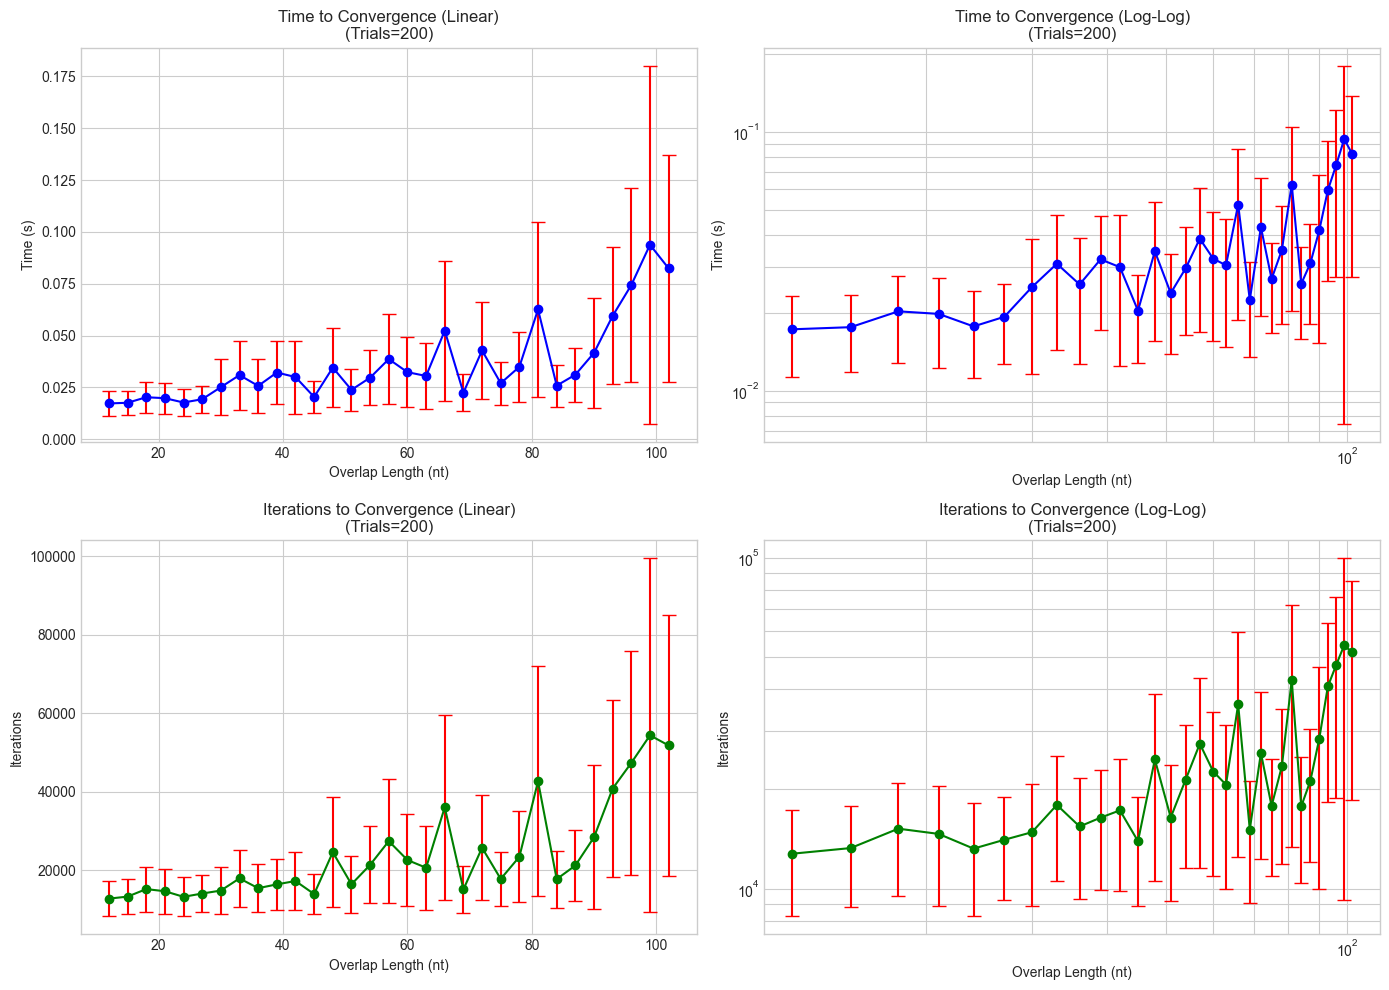

In [14]:
# Plotting Benchmark 1 Results

if results_overlap['x']:
    x = np.array(results_overlap['x'])
    y = np.array(results_overlap['time_mean'])
    y_err = np.array(results_overlap['time_std'])
    y_safe = np.maximum(y, 1e-9)

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()

    # 1. Linear Time
    axs[0].errorbar(x, y, yerr=y_err, fmt='o-', capsize=5, ecolor='red', color='blue')
    axs[0].set_title(f'Time to Convergence (Linear)\n(Trials={NUM_TRIALS})')
    axs[0].set_xlabel('Overlap Length (nt)')
    axs[0].set_ylabel('Time (s)')

    # 2. Log-Log Time
    valid_mask = (x > 0) & (y_safe > 0)
    if np.any(valid_mask):
        axs[1].errorbar(x[valid_mask], y_safe[valid_mask], yerr=y_err[valid_mask], fmt='o-', capsize=5, ecolor='red', color='blue')
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')
        axs[1].set_title(f'Time to Convergence (Log-Log)\n(Trials={NUM_TRIALS})')
        axs[1].set_xlabel('Overlap Length (nt)')
        axs[1].set_ylabel('Time (s)')
        axs[1].grid(True, which="both", ls="-")

    # 3. Iterations (Linear)
    axs[2].errorbar(x, results_overlap['iter_mean'], yerr=results_overlap['iter_std'], fmt='o-', capsize=5, ecolor='red', color='green')
    axs[2].set_title(f'Iterations to Convergence (Linear)\n(Trials={NUM_TRIALS})')
    axs[2].set_xlabel('Overlap Length (nt)')
    axs[2].set_ylabel('Iterations')

    # 4. Iterations (Log-Log)
    iter_mean = np.array(results_overlap['iter_mean'])
    iter_std = np.array(results_overlap['iter_std'])
    iter_safe = np.maximum(iter_mean, 1e-9)
    
    valid_mask_iter = (x > 0) & (iter_safe > 0)
    if np.any(valid_mask_iter):
        axs[3].errorbar(x[valid_mask_iter], iter_safe[valid_mask_iter], yerr=iter_std[valid_mask_iter], fmt='o-', capsize=5, ecolor='red', color='green')
        axs[3].set_xscale('log')
        axs[3].set_yscale('log')
        axs[3].set_title(f'Iterations to Convergence (Log-Log)\n(Trials={NUM_TRIALS})')
        axs[3].set_xlabel('Overlap Length (nt)')
        axs[3].set_ylabel('Iterations')
        axs[3].grid(True, which="both", ls="-")

    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

NOTE , NEED TO REDO ENSURING ALL SELECTED OVERLAP LENGTHS USE THE OPTIMAL READING FRAME!!
I THINK THIS IS CAUSING NOISE IN THE DATA

## Benchmark 2: Convergence Traces
Visualizing the energy trajectory of individual runs to confirm they settle into the target range.

Generating convergence traces for Overlap 60 (5 trials)...


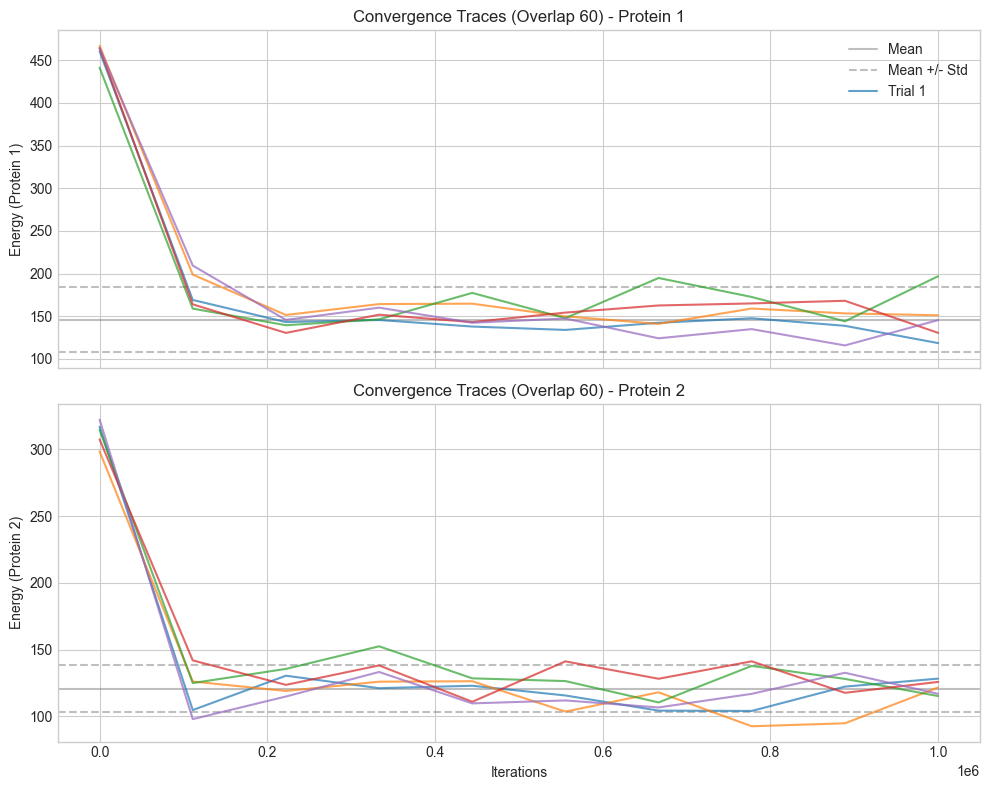

In [15]:
print(f"Generating convergence traces for Overlap {TRACE_OVERLAP} ({TRACE_TRIALS} trials)...")

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Thresholds
axs[0].axhline(y=mean_e1, linestyle='-', color='gray', alpha=0.5, label='Mean')
axs[0].axhline(y=mean_e1 + std_e1, linestyle='--', color='gray', alpha=0.5, label='Mean +/- Std')
axs[0].axhline(y=mean_e1 - std_e1, linestyle='--', color='gray', alpha=0.5)

axs[1].axhline(y=mean_e2, linestyle='-', color='gray', alpha=0.5)
axs[1].axhline(y=mean_e2 + std_e2, linestyle='--', color='gray', alpha=0.5)
axs[1].axhline(y=mean_e2 - std_e2, linestyle='--', color='gray', alpha=0.5)

for i in range(TRACE_TRIALS):
    initial_seq = og.initial_seq_no_stops(prot1_len, prot2_len, TRACE_OVERLAP, quiet=True)
    
    # Use the _int generator which returns history
    # whentosave=0.1 means 1000 saves per run (100/0.1). 
    
    final_seq, accepted, hist_e1, hist_e2, final_Es = og.overlapped_sequence_generator_int(
        dca_params_1, dca_params_2, initial_seq, 
        numberofiterations=TRACE_ITERATIONS, 
        whentosave=0.1, # Save frequently
        quiet=True,
        T1=T1, T2=T2
    )
    
    # Plot traces
    # Create x-axis based on length of history
    x_axis = np.linspace(0, TRACE_ITERATIONS, len(hist_e1))
    
    axs[0].plot(x_axis, hist_e1, alpha=0.7, label=f'Trial {i+1}' if i==0 else "")
    axs[1].plot(x_axis, hist_e2, alpha=0.7)

axs[0].set_ylabel('Energy (Protein 1)')
axs[0].set_title(f'Convergence Traces (Overlap {TRACE_OVERLAP}) - Protein 1')
axs[0].legend(loc='upper right')

axs[1].set_ylabel('Energy (Protein 2)')
axs[1].set_title(f'Convergence Traces (Overlap {TRACE_OVERLAP}) - Protein 2')
axs[1].set_xlabel('Iterations')

plt.tight_layout()
plt.show()

## Benchmark 3: Sequence Diversity
Analyzing the diversity of generated sequences for different overlap lengths using pairwise Hamming distance.

Analyzing Sequence Diversity (20 trials per overlap)...
  Generating sequences for overlap 10...
  Generating sequences for overlap 40...
  Generating sequences for overlap 70...
  Generating sequences for overlap 95...


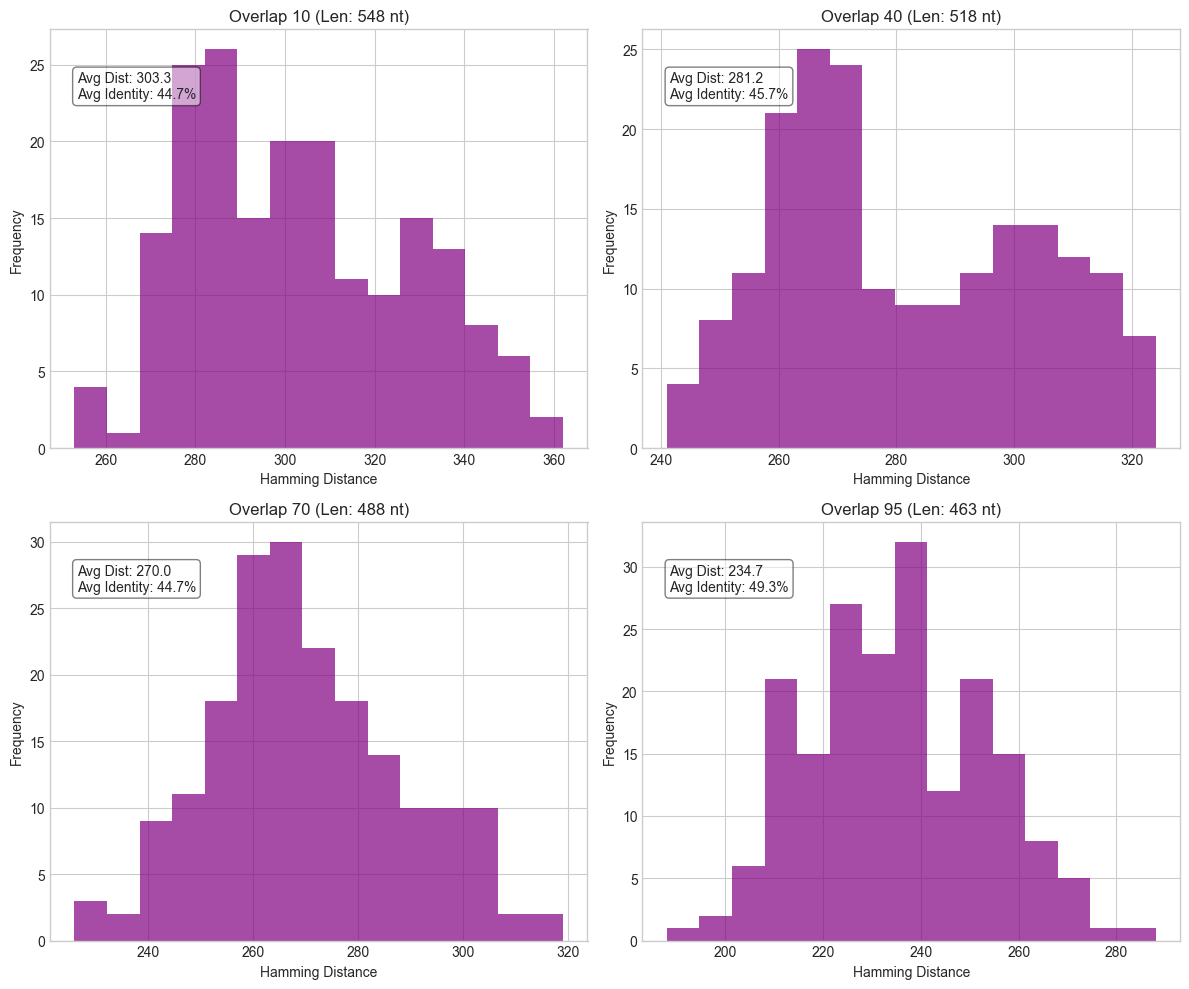

Diversity Analysis Complete.


In [16]:
def calculate_hamming_distances(sequences):
    distances = []
    n = len(sequences)
    seq_len = len(sequences[0])
    for i in range(n):
        for j in range(i + 1, n):
            # Simple Hamming distance
            dist = sum(c1 != c2 for c1, c2 in zip(sequences[i], sequences[j]))
            distances.append(dist)
    return distances, seq_len

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

print(f"Analyzing Sequence Diversity ({DIVERSITY_TRIALS} trials per overlap)...")

for idx, overlap in enumerate(DIVERSITY_OVERLAPS):
    if idx >= 4: break # Limit to 4 plots
    
    print(f"  Generating sequences for overlap {overlap}...")
    sequences = []
    
    for _ in range(DIVERSITY_TRIALS):
        initial_seq = og.initial_seq_no_stops(prot1_len, prot2_len, overlap, quiet=True)
        # Run until convergence
        iters, converged, e1, e2 = og.overlapped_sequence_generator_convergence(
            dca_params_1, dca_params_2, initial_seq,
            mean_e1=mean_e1, std_e1=std_e1,
            mean_e2=mean_e2, std_e2=std_e2,
            max_iterations=MAX_ITERATIONS,
            T1=T1, T2=T2
        )
        
        
        
        final_seq_str, _, _, _, _ = og.overlapped_sequence_generator_int(
             dca_params_1, dca_params_2, initial_seq,
             numberofiterations=100000, # Should be enough for most
             quiet=True,
             T1=T1, T2=T2
        )
        sequences.append(final_seq_str)

    # Calculate distances
    dists, seq_len = calculate_hamming_distances(sequences)
    
    # Plot Histogram
    axs[idx].hist(dists, bins=15, color='purple', alpha=0.7)
    axs[idx].set_title(f'Overlap {overlap} (Len: {seq_len} nt)')
    axs[idx].set_xlabel('Hamming Distance')
    axs[idx].set_ylabel('Frequency')
    
    # Add stats
    avg_dist = np.mean(dists)
    avg_identity = 100 * (1 - avg_dist / seq_len)
    axs[idx].text(0.05, 0.9, f'Avg Dist: {avg_dist:.1f}\nAvg Identity: {avg_identity:.1f}%', 
                  transform=axs[idx].transAxes, verticalalignment='top', 
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()
print("Diversity Analysis Complete.")